## 第一次讀書會-第4組
## 對ptt與東森新聞上的龍龍與老K炎上事件進行情緒分析

- 課程：社群媒體分析
- 指導老師：黃三益 教授
- 組長：M104020048 顏宏任
- 組員：M104020011 王培碩、M104020013 黃威凱、M094020038 李佳蓉、M104020029 邱承漢、M092040020 陳佳伶

In [1]:
# 確認當前工作目錄
%pip install wordcloud
%pwd

Note: you may need to restart the kernel to use updated packages.


'C:\\Users\\peso8\\第4組_HW1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

## 2. 資料前處理



### 2.1 基本資料介紹

2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2021-09-30 ~ 2021-10-09 所有文章
- 資料集： Ptt_Dragon_articleMetaData_1020.csv/Ptt_Dragon_articleReviews_1020.csv
- 關鍵字：'龍龍','老K','薩泰爾','康姐','老男孩','雞排妹'
- 情緒字典：正負向字典採用NTUSD(台大)情緒字典。
- 聲量字典：自定義人名/單位字典(龍龍、老K、博恩...)。
- 斷詞字典：自定義21個項目(雞排妹 10 n、薩泰爾 10 n、馬謖 10 n...)。
- 資料時間：2021-09-30 ~ 2021-10-09

主要分析ptt上網友的相關討論，並對比東森新聞上大家的討論情形。本次主要針對以下方向分析：
1. 龍龍炎上事件的討論大概出現在哪個時間點，話題高峰在哪裡？
2. 正面和負面的討論內容各是甚麼，有沒有時間點上的差異？
3. 正面和負面討論的情緒分數大約多少？
4. 正面和負面文章中最高聲量的人物是誰？

事件始末：
- 9/30 龍龍發文控訴遭老K霸凌
- 10/2 博恩出面解釋
- 10/2 晚間老K狠酸龍龍：喜劇毒瘤
- 10/7 雞排妹直播還原事情真相並扯出外案點名網紅小生：噁男給我滾
- 10/8 我是小生發文並正式發出律師聲明要求道歉與解釋

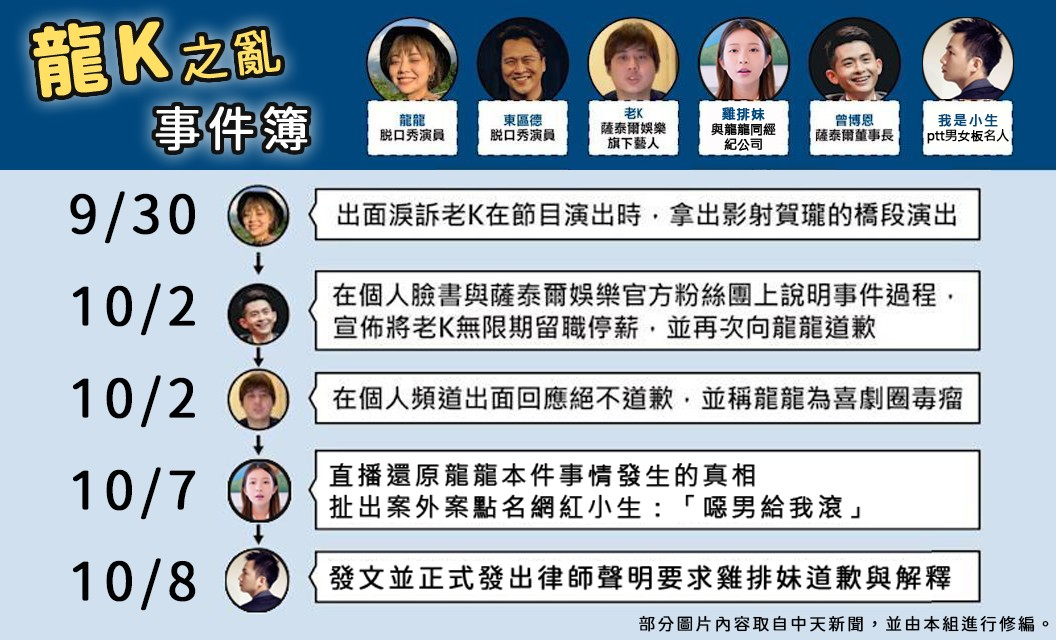

In [4]:
#匯入資料
MetaData = pd.read_csv('./raw_data/Ptt_Dragon_articleMetaData_1020.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/Ptt_Dragon_articleReviews_1020.csv', encoding='UTF-8')

In [5]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 1285 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,我花錢看過全部 沒記錯的話 龍龍台上攻擊老k也很狠 但是畢竟說好不提還提 就站不住\n腳\n...
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:26:31,https://www.ptt.cc/bbs/Gossiping/M.1633019194....,Dinenger,Gossiping,2,2,0,龍龍是女的喔？！\n那這樣我就不意外了\n\n脫口秀本來整天酸別人\n輪到自己被酸就受不了\...
2,Re:[新聞]遭脫稿演出霸凌 龍龍淚崩「等不到道歉」,2021/09/30,16:59:20,https://www.ptt.cc/bbs/Gossiping/M.1633021162....,popia77,Gossiping,19,12,0,以\n要\n到\n然\n我\n回\n龍龍的經紀人康姐\n跟雞排妹同一個經紀人嗎？\n好像懂了...


In [6]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 67465 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,l11111111,→,2021-10-01 00:21:00,:人家女生耶
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,Ponimp,推,2021-10-01 00:22:00,:龍龍算大咖喔?
2,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,whitenoise,推,2021-10-01 00:23:00,:Re稿時都說好不講了，現場來這齣是擺


In [7]:
# 再篩一次文章
keywords = ['龍龍','老K','薩泰爾','康姐','老男孩','雞排妹']
toMatch = '|'.join(keywords)



In [8]:
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1215, 10)


In [9]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [10]:
print(Reviews.shape)
Reviews.head(3)

(64679, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:人家女生耶
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:龍龍算大咖喔?
2,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:Re稿時都說好不講了，現場來這齣是擺


### 2.2 資料清理  
- 去除NA值
- 正規化資料清理
- 去除不是中文的字詞
- 本次分析事件中有多個名詞中有包含英文字(老K、STR等...)，因此本次資料處理有保留英文字母。

In [11]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [12]:
def clean(row):
    result = re.sub('[\t]{2,}', '', row)
    result = re.sub('#_*', '', result)
    result = re.sub('\\n', '', result)
    result = re.sub('\s{2,}', '', result)
    result = re.sub('(http|https)://.*', '', result)
    result = re.sub('[0-9]', '', result)
    return result

In [13]:
MetaData['sentence'] = MetaData.sentence.apply(clean)
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,我花錢看過全部 沒記錯的話 龍龍台上攻擊老k也很狠 但是畢竟說好不提還提 就站不住腳不過從另...
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:26:31,https://www.ptt.cc/bbs/Gossiping/M.1633019194....,Dinenger,Gossiping,2,2,0,龍龍是女的喔？！那這樣我就不意外了脫口秀本來整天酸別人輪到自己被酸就受不了有夠失格像我整天在...
2,Re:[新聞]遭脫稿演出霸凌 龍龍淚崩「等不到道歉」,2021/09/30,16:59:20,https://www.ptt.cc/bbs/Gossiping/M.1633021162....,popia77,Gossiping,19,12,0,以要到然我回龍龍的經紀人康姐跟雞排妹同一個經紀人嗎？好像懂了什麼（咦老K你還是開記者會道歉吧XD


In [14]:
Reviews['sentence'] = Reviews.cmtContent.apply(clean)
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,sentence
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:人家女生耶,:人家女生耶
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:龍龍算大咖喔?,:龍龍算大咖喔?
2,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:Re稿時都說好不講了，現場來這齣是擺,:Re稿時都說好不講了，現場來這齣是擺


In [15]:
#MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [16]:
#MetaData.head(3)
#MetaData['sentence']

In [17]:
#Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))
#Reviews.head(3)
#Reviews['cmtContent']

### 2.3 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [18]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\peso8\第4組_HW1\dict\dict.txt.big ...
Dumping model to file cache C:\Users\peso8\AppData\Local\Temp\jieba.u9f4b77bff8b17930a4c2a0ed23edd777.cache
Loading model cost 1.412 seconds.
Prefix dict has been built successfully.


- 這裡發現像是'雞排妹','薩泰爾'等文字會被斷開，因此自行手動加入斷詞，並將freq權重設為20000，以避免字詞被斷開。

In [19]:
# 參數形式手動加入字詞
words = ['雞排妹','薩泰爾','馬謖','東區德', '女權自助餐', '屠龍', '龍K', '龍k', '老K', '老k', '老男孩直播', '天線寶寶', '賀瓏',
        '呱吉', '康姐', '鄭家純', '博恩', '假哭', '林千聿', '打太極', '被陰dd']
for w in words:
    jieba.add_word(w, freq=20000, tag=None)

In [20]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [21]:
MetaData['word'] = MetaData.sentence.apply(getToken)

In [22]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [23]:
MetaData_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,我花錢看過全部 沒記錯的話 龍龍台上攻擊老k也很狠 但是畢竟說好不提還提 就站不住腳不過從另...,花錢
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,我花錢看過全部 沒記錯的話 龍龍台上攻擊老k也很狠 但是畢竟說好不提還提 就站不住腳不過從另...,看過
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,我花錢看過全部 沒記錯的話 龍龍台上攻擊老k也很狠 但是畢竟說好不提還提 就站不住腳不過從另...,記錯


In [24]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [25]:
# 將word欄位展開
Reviews_token = Reviews.explode('word') 

In [26]:
Reviews_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,sentence,word
0,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:人家女生耶,:人家女生耶,女生
1,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:龍龍算大咖喔?,:龍龍算大咖喔?,龍龍算
2,Re:[新聞]「內鬨炎上」｜「博恩也管不住他」,2021/09/30,16:20:17,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,O26RZ,Gossiping,45,10,4,:Re稿時都說好不講了，現場來這齣是擺,:Re稿時都說好不講了，現場來這齣是擺,Re


In [27]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2021/09/30,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,花錢
0,2021/09/30,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,看過
0,2021/09/30,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,記錯
0,2021/09/30,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,龍龍
0,2021/09/30,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,台上


In [28]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [29]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

,artDate,word,size
14522,2021-10-02,老K,1549
18351,2021-10-02,龍龍,1077
6553,2021-10-02,博恩,1041
16843,2021-10-02,道歉,826
5965,2021-10-02,公司,800
22427,2021-10-03,塔綠班,699
14523,2021-10-02,老k,658
17670,2021-10-02,雙標,617
31300,2021-10-03,雙標,613
28559,2021-10-03,老K,560


## 3. lexicon-base 情緒分析
- 進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。
- 為了分析聲量，我們在此加入聲量字典(name)，以進行後續分析。

In [30]:
filepath = ['negative','positive','name']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split("\n"),file])

In [31]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,笑死,negative
1,幹,negative
2,一下子爆發,negative
3,一下子爆發的一連串,negative
4,一巴掌,negative
...,...,...
11094,薩泰爾,name
11095,老男孩,name
11096,康衣庭,name
11097,呱吉,name


### 3.2 情緒字典與斷詞結果進行合併
- 將情緒字典與斷詞結果進行合併。
- 可以先觀察每天的ptt文章數量，大約在10/01號事件爆發之後才比較有討論的聲量，並在10/07雞排妹直播後有第二波聲量，之後便開始下降。

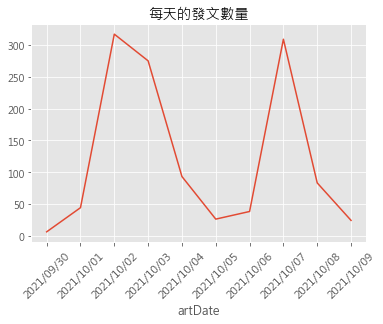

In [32]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

### 3.3 正負向情緒及聲量分數折線圖
分別畫出文集中，正向（positive）、負向（negative）情緒與聲量的折線圖。

In [33]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-09-30,name,57
1,2021-09-30,negative,103
2,2021-09-30,positive,46
3,2021-10-01,name,420
4,2021-10-01,negative,930


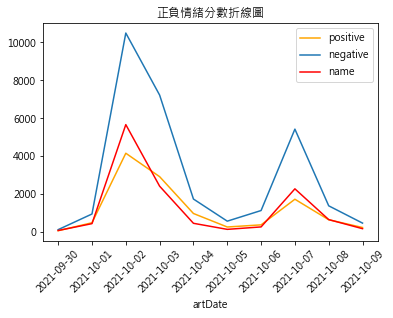

In [34]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']
r = sentiment_count[sentiment_count['sentiments']=='name']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.plot(n['artDate'].tolist(), r['size'], label='name',color="red")
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

- 畫出每天的情緒總分數，可以看到情緒以負面為主。 
- 10/02號10/07有最多聲量，約在10/8號之後討論度逐漸下降。

### 3.4 正負向情緒分數比例折線圖圖

In [35]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

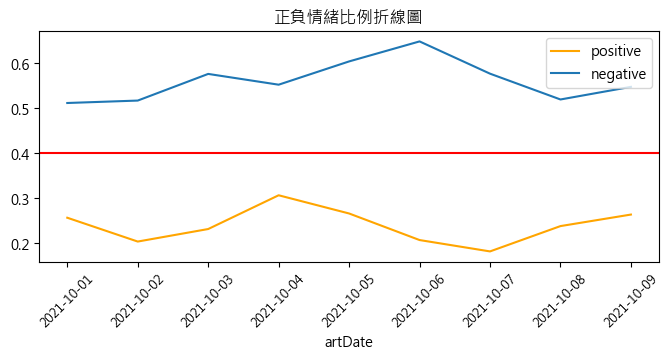

In [36]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/09/30']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']
r = sentiment_count_r[sentiment_count_r['sentiments']=='name']

plt.figure(figsize=(8,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #使中文能正常顯示
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
#plt.plot(n['artDate'].tolist(), r['ratio'], label='name',color="red")
plt.xticks(rotation= 45, fontsize=9)
plt.legend(loc=1) #顯示圖例
#plt.axvline(x=datetime.strptime('2021-10-02', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-07', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-08', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-08', "%Y-%m-%d"), color="red", ls="-")
plt.axhline(y=0.4,color="red", ls="-")
plt.xlabel('artDate')
plt.show()

### 3.5 文字雲
- 針對10/02事發第三天、10/07雞排妹直播、10/08小生要求道歉，畫出該天的文字雲。
- 如果文字雲中的字詞大小越大，代表出現頻率越高。

In [37]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

### 2021-10-02 文字雲
10/02的文字雲，我們可以看到出現最多的字是“薩泰爾”、“賀瓏”、“女權”、“自助餐”、“笑死”等，可以得知在ptt上認為龍龍是雙標的輿論還是較多。

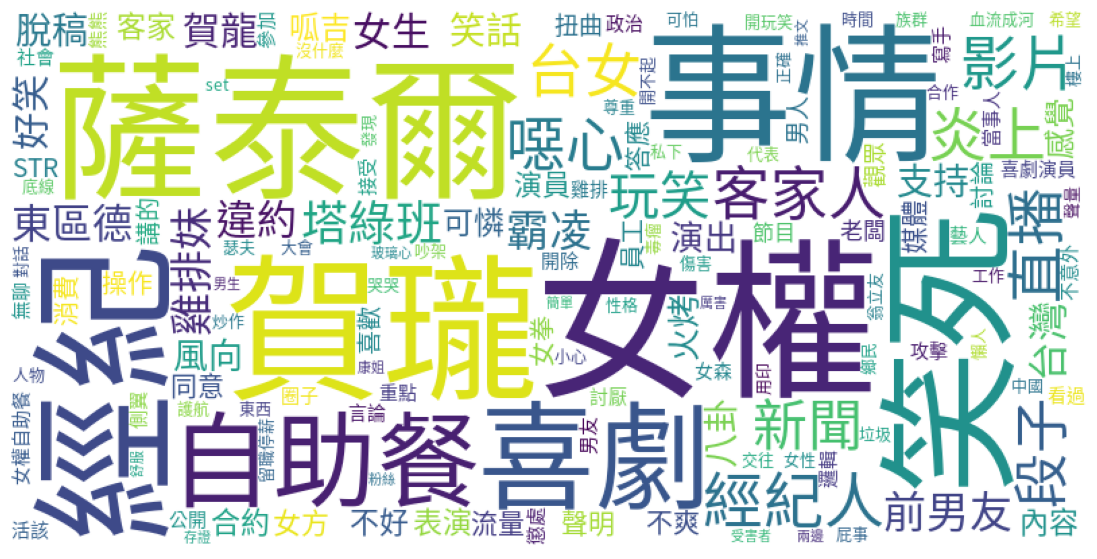

In [38]:
dict_1002 = Wc_dict(word_count,"2021-10-02",450,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1002)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-10-07 文字雲

在10/07號雞排妹直播後，可以發現最大的關鍵字是“老K”、“笑死”、“切割”、“博恩”等字詞，以及訴說龍龍忘記段子的“記錯”、“失智”等諷刺的詞彙。

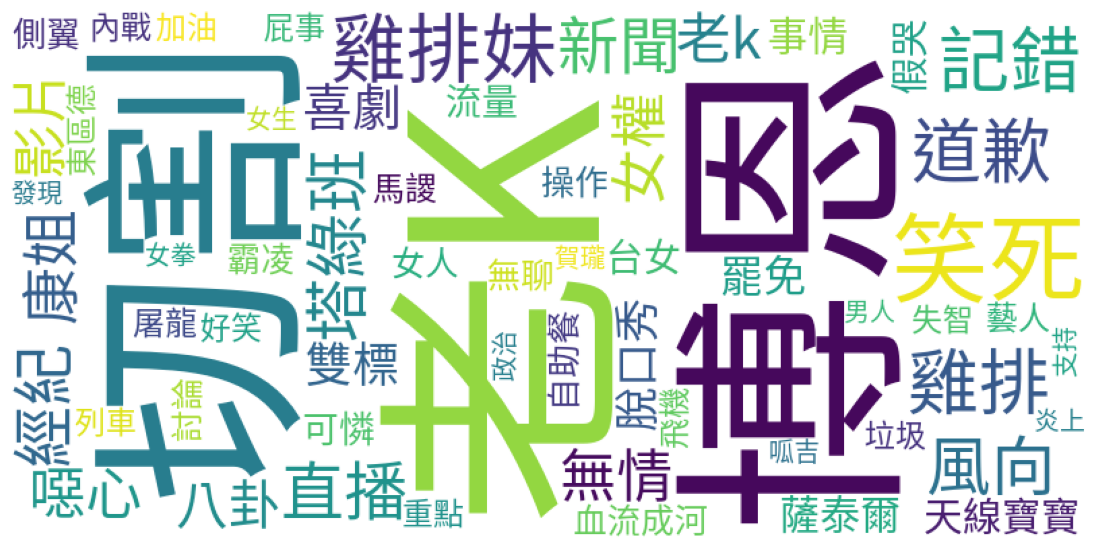

In [39]:
dict_1007 = Wc_dict(word_count,"2021-10-07",450,50)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1007)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2021-10-08 文字雲
10/08這裡可以看到比較有趣的關鍵字是"小生"、“法院”，這是因為雞排妹在直播直接說：「"我是小生"這位網紅是噁男」而遭到提告。而其他也有看到“無聊”、“血流成河”等關鍵字可以看出一部分鄉民依然在看戲，而一部分已經覺得無趣了。

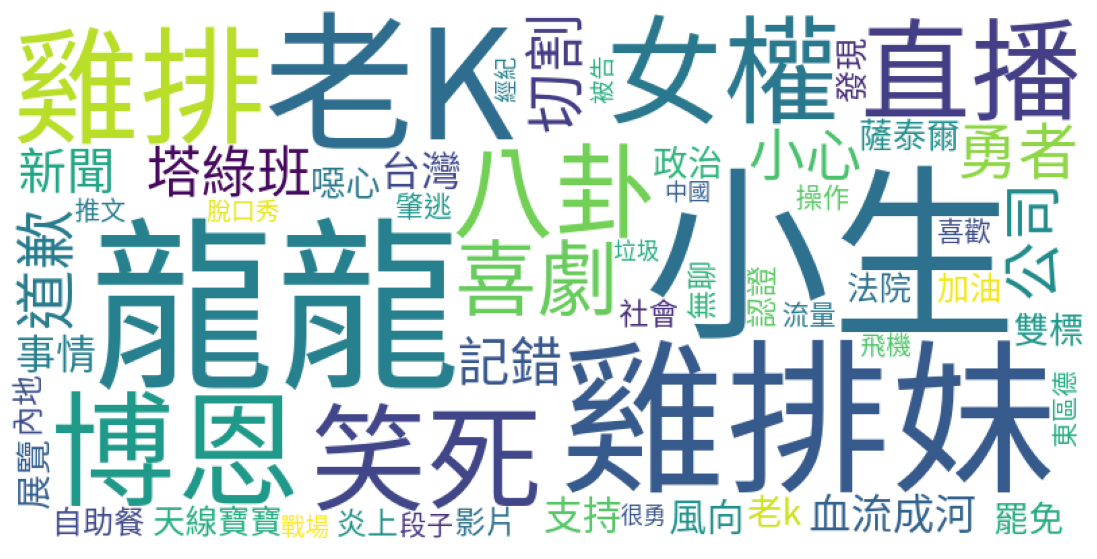

In [40]:
dict_1008 = Wc_dict(word_count,"2021-10-08",200,15)

wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1008)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字以及聲量字出現的詞頻，並找出情緒的代表字。

In [41]:
sentiment_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
502,老K,name,2909
672,龍龍,name,2625
105,博恩,name,2103
156,噁心,negative,1766
613,道歉,negative,1582


本次事件中有幾個重點人物的名子常常被網友打錯字，因此本組在這邊有進行了錯(異)字合併的動作，讓個人的聲量數據可以合併在同一條長條圖中。

In [42]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = sentiment_sum[sentiment_sum["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

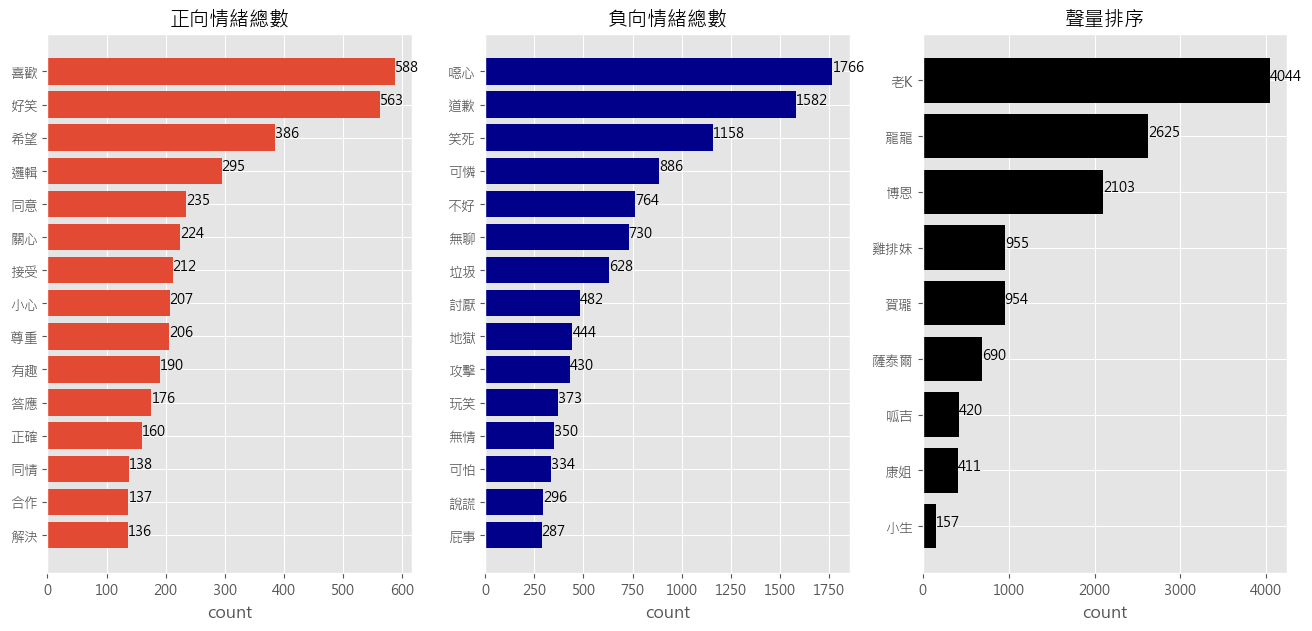

In [43]:
plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])
for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(132)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")
for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(133)
plt.title('聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")
for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.show()

另外，也可以依據不同日期觀察情緒代表字的變化。
### 2021-10-02 正負情緒代表字

In [44]:
sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_1002 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-02"].sort_values(by=['size'], ascending=False)
sentiment_1002.head()

,artDate,word,sentiments,size
470,2021-10-02,老K,name,1549
604,2021-10-02,龍龍,name,1077
166,2021-10-02,博恩,name,1041
560,2021-10-02,道歉,negative,826
471,2021-10-02,老k,name,658


In [45]:
p_sum = sentiment_1002[sentiment_1002["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1002[sentiment_1002["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = sentiment_1002[sentiment_1002["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

- 從這裡可以看出10/02還在談論老K違約的事件較多，而被判斷為正向的“喜歡”為中性詞彙。“玩笑”、“笑死”實則為反諷。

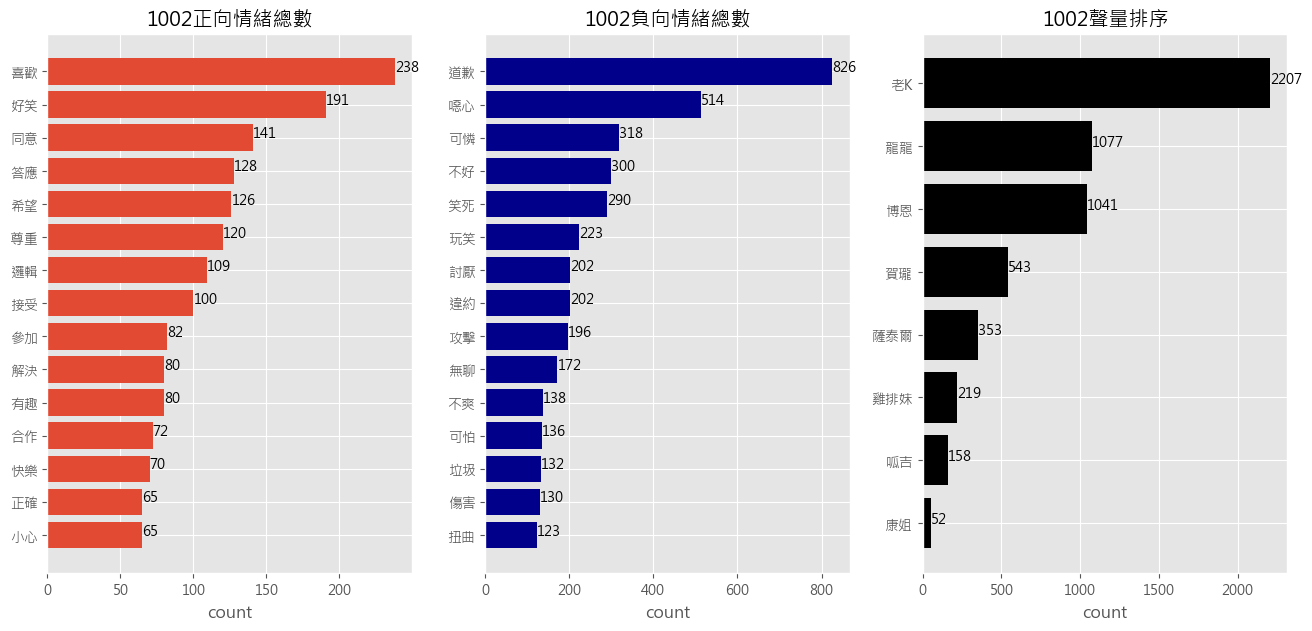

In [46]:
# p_sum = sentiment_1002[sentiment_1002["sentiments"]=="positive"].head(15).sort_values(by=['size'])
# n_sum = sentiment_1002[sentiment_1002["sentiments"]=="negative"].head(15).sort_values(by=['size'])
# r_sum = sentiment_1002[sentiment_1002["sentiments"]=="name"].head(15).sort_values(by=['size'])

plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('1002正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])
for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(132)
plt.title('1002負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")
for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(133)
plt.title('1002聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")
for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))


plt.show()

### 2021-10-07 正負情緒代表字

In [47]:
#篩選日期
sentiment_1007 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-07"].sort_values(by=['size'], ascending=False)
sentiment_1007.head()

,artDate,word,sentiments,size
1580,2021-10-07,龍龍,name,519
1500,2021-10-07,老K,name,430
1313,2021-10-07,博恩,name,378
1338,2021-10-07,噁心,negative,344
1465,2021-10-07,無情,negative,334


In [48]:
p_sum = sentiment_1007[sentiment_1007["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1007[sentiment_1007["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = sentiment_1007[sentiment_1007["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

- 這裡可以看出10/07雞排妹開直播還原事情真相，並扯出案外案點名網紅小生：「噁男給我滾」。因此雞排妹在這天的聲量衝到第四名。
- 被判斷為正向的“希望”從10/02的第五名來到了第一名，可見網友對於這件事有許多期待。
- “噁心”在10/07衝到了負向情緒排名榜的第一名。

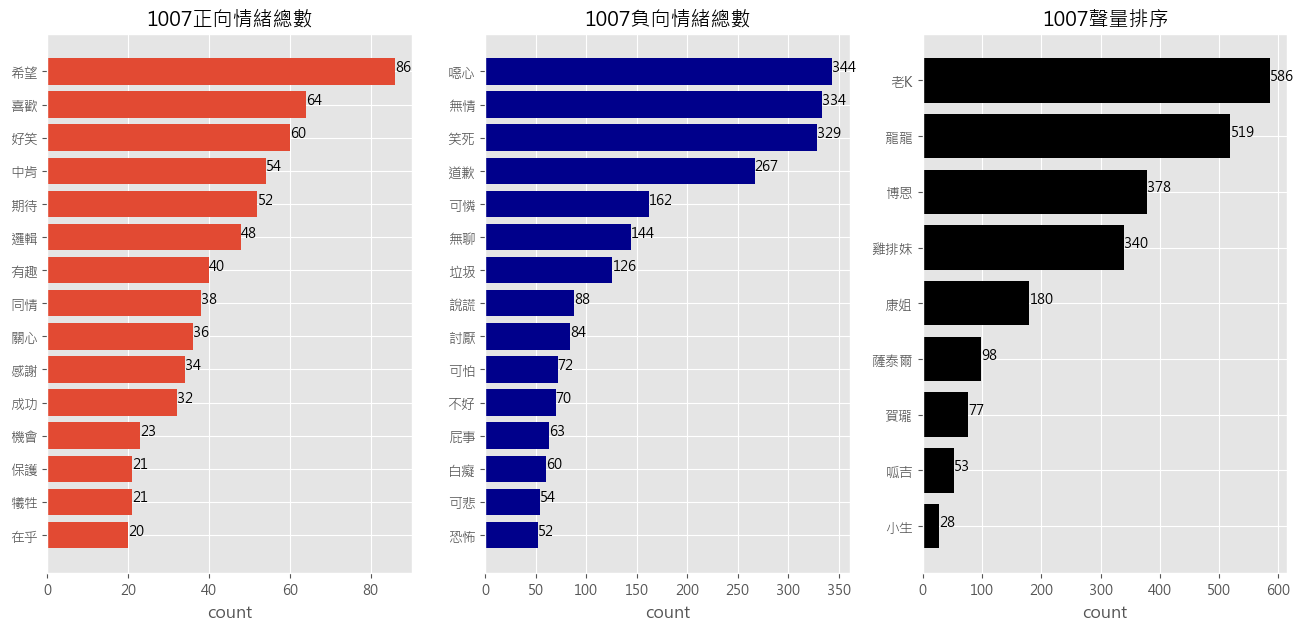

In [49]:
plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('1007正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(132)
plt.title('1007負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(133)
plt.title('1007聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")

for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))


plt.show()

### 2021-10-08 正負情緒代表字

In [50]:
#篩選日期
sentiment_1008 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-08"].sort_values(by=['size'], ascending=False)
sentiment_1008.head()

,artDate,word,sentiments,size
1618,2021-10-08,小生,name,129
1688,2021-10-08,龍龍,name,128
1685,2021-10-08,雞排妹,name,101
1656,2021-10-08,老K,name,84
1587,2021-10-08,博恩,name,83


In [51]:
p_sum = sentiment_1008[sentiment_1008["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1008[sentiment_1008["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = sentiment_1008[sentiment_1008["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

- 10/07雞排妹點名網紅小生：「噁男給我滾」所以在10/08的聲量分析可看到"小生"的聲量衝到了第一名，勝過原事件的主角：龍龍跟老K。

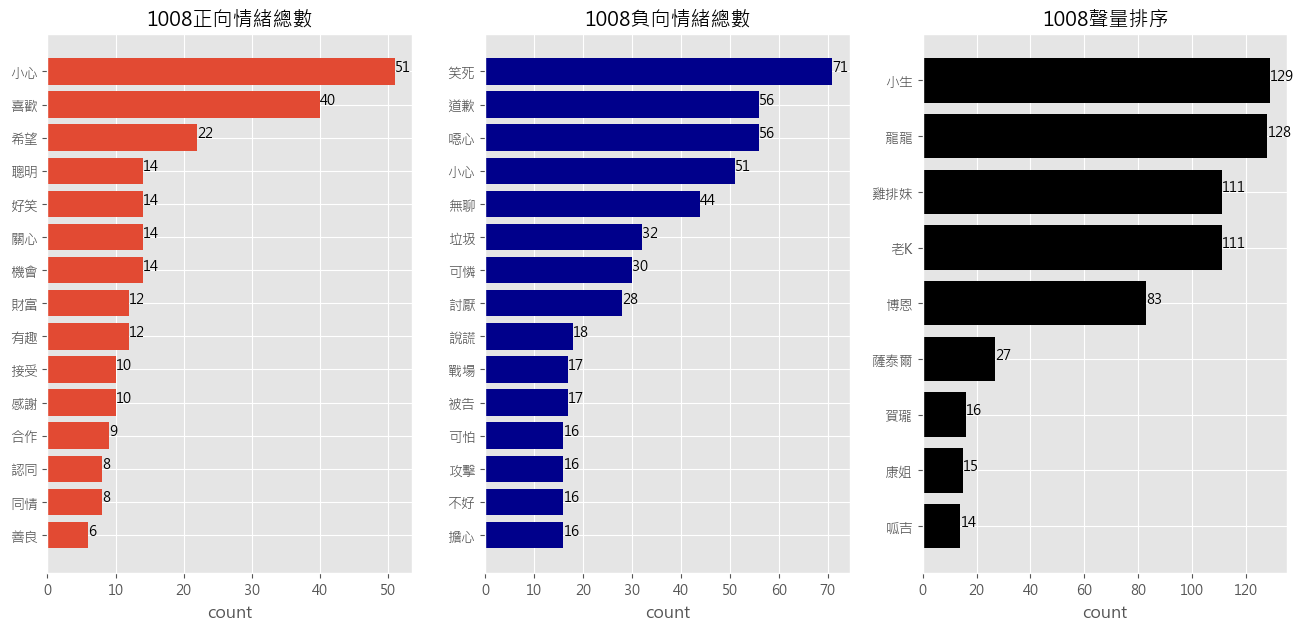

In [52]:
plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('1008正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))
    

plt.subplot(132)
plt.title('1008負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")

for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

    
plt.subplot(133)
plt.title('1008聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")

for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.show()

### 3.7 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [53]:
article_type = (data.merge(df_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,name,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1633018819....,7,25,16
1,https://www.ptt.cc/bbs/Gossiping/M.1633019194....,2,3,2
2,https://www.ptt.cc/bbs/Gossiping/M.1633021162....,6,3,0
3,https://www.ptt.cc/bbs/Gossiping/M.1633037447....,7,21,8
4,https://www.ptt.cc/bbs/Gossiping/M.1633044412....,13,10,6


In [54]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,1041
1,positive,167


### 正負情緒文章數量統計圖

In [55]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

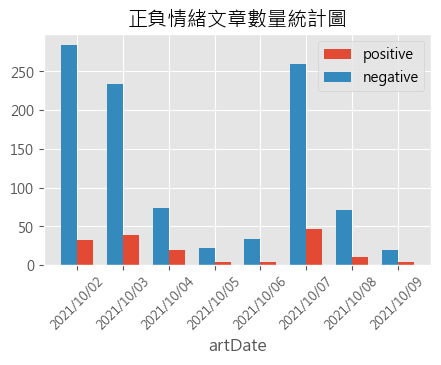

In [56]:
ap = article_type_date[(article_type_date["type"]=="positive")&(article_type_date["artDate"]>="2021/10/02")&(article_type_date["artDate"]<="2021/3/25")]
an = article_type_date[(article_type_date["type"]=="negative")&(article_type_date["artDate"]>="2021/10/02")&(article_type_date["artDate"]<="2021/3/25")]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")

plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')

plt.show()

- 可以看到負面文章較多。

### 3.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併。

In [57]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

### 情緒關鍵字:負面情緒文章

In [58]:
negative_article = (negative_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

In [59]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = negative_article[negative_article["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

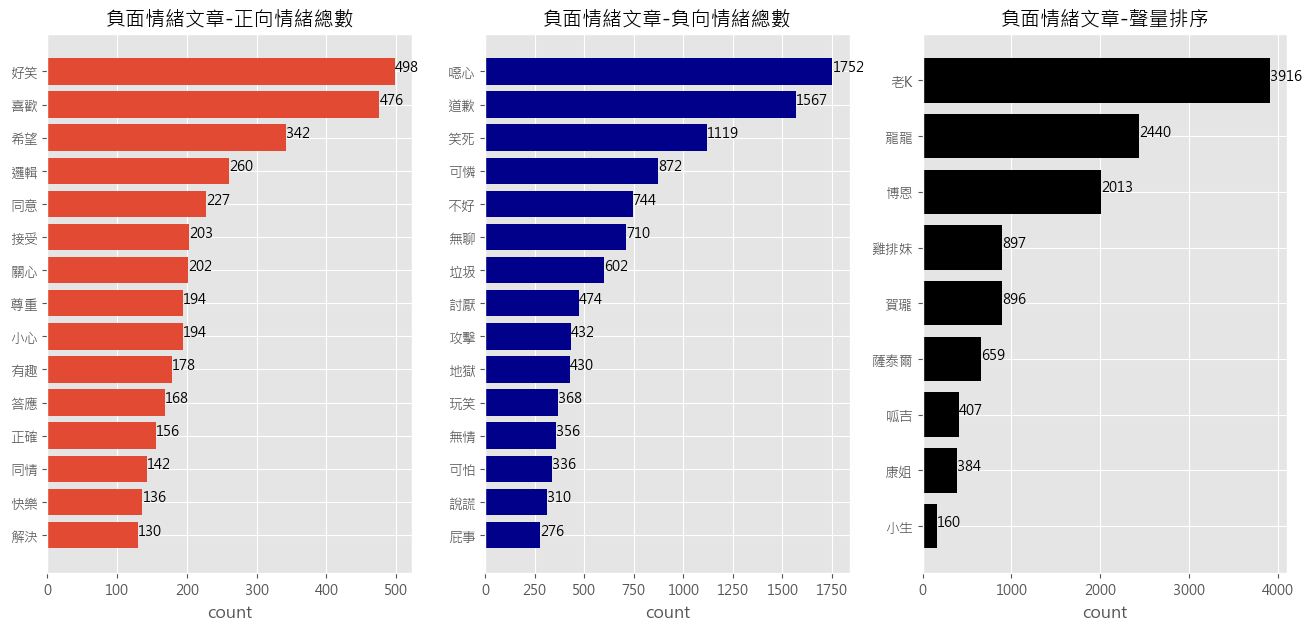

In [60]:
plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('負面情緒文章-正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])
for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(132)
plt.title('負面情緒文章-負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")
for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(133)
plt.title('負面情緒文章-聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")
for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))


plt.show()

- 以負面情緒文章來說，老K在這些文章中的聲量排序接近4000，勝過第二名的龍龍非常多，由此可知這些負面情緒文章中，最常被提及的人可能就是老K。

### 情緒關鍵字:正面情緒文章

In [61]:
positive_article = (positive_article.merge(df_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

In [62]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])
r_sum = positive_article[positive_article["sentiments"]=="name"].head(15).sort_values(by=['size'])

# 合併 name字典中的名字(本名、別名或錯別字)
def get_category(x):
    if (x == '老K' or x =='老k'):
        return '老K'
    elif (x == '賀龍' or x =='賀瓏'):
        return '賀瓏'
    elif (x == '康姐' or x =='康衣庭'):
        return '康姐'
    elif (x == '雞排妹' or x =='鄭家純'):
        return '雞排妹'
    else:
        return x

r_sum["word"] = r_sum["word"].map(get_category)
r_sum=r_sum.groupby(['word'], as_index=False).agg({'size': 'sum'})

r_sum=r_sum.sort_values(by=['size'],ascending=True)

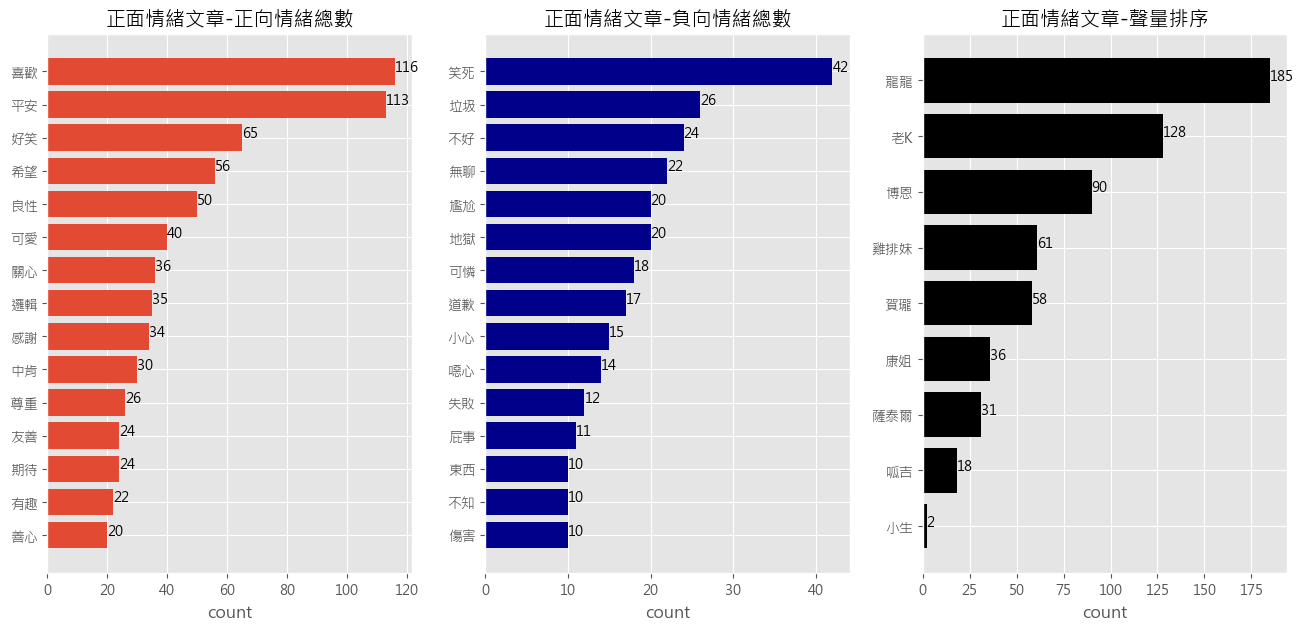

In [63]:
plt.figure(figsize=(16,7))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('正面情緒文章-正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])
for wi, si in zip(p_sum['word'], p_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(132)
plt.title('正面情緒文章-負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")
for wi, si in zip(n_sum['word'], n_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.subplot(133)
plt.title('正面情緒文章-聲量排序')
plt.xlabel('count')
plt.barh(r_sum['word'],r_sum['size'],color="black")
for wi, si in zip(r_sum['word'], r_sum['size']):
    plt.text(si, wi, "{}".format(si))

plt.show()

- 正面情緒文章看來，龍龍在正面文章中的聲量較高，由此可知這些正面文章中，龍龍較常被提及到。

### 3.9與東森新聞比較
看看不同的社群媒體對於同一個事件的情緒是否有差異。

In [64]:
news = pd.read_csv('./raw_data/Dragon_news_articleMetaData_1020.csv', encoding='UTF-8')

In [65]:
print(f"共有 {news.shape[0]} 篇東森新聞文章")
news.head()

共有 21 篇東森新聞文章


,artTitle,artDate,artTime,artUrl,sentence
0,脫口秀女星龍龍痛訴遭霸凌 臉書長文吐心聲：底線被踐踏｜東森新聞,2021/09/30,00:00:00,https://news.ebc.net.tw/news/article/280749,脫口秀演員龍龍爆料遭到「薩泰爾娛樂」成員老K霸凌，在喜劇節目炎上BURN的數千名觀眾前，拿她...
1,老K直播吐「被O到性格扭曲」 龍龍痛哭要一個道歉｜東森新聞,2021/10/01,00:00:00,https://news.ebc.net.tw/news/article/280783,知名脫口秀演員龍龍先前受邀到喜劇節目炎上BURN演出，然而卻遭節目固定「老K」霸凌。龍龍指控...
2,龍龍遭霸凌風暴擴大 博恩親上火線崩潰淚訴內幕｜東森新聞,2021/10/02,00:00:00,https://news.ebc.net.tw/news/article/280947,知名脫口秀演員龍龍先前受邀到喜劇節目炎上BURN演出，然而卻遭節目固定「老K」霸凌。龍龍指控...
3,怒轟龍龍「喜劇圈毒瘤」 老K痛訴：絕不向這個人道歉｜東森新聞,2021/10/02,00:00:00,https://news.ebc.net.tw/news/article/281042,脫口秀演員龍龍近日爆出遭同行老K於炎上BURN節目上公眾霸凌，不僅在舞台上脫稿演出，事後還在...
4,老K狠酸龍龍「毒瘤」 再嗆喬瑟夫是孬種｜東森新聞,2021/10/03,00:00:00,https://news.ebc.net.tw/news/article/281151,脫口秀演員龍龍與薩泰爾娛樂成員老K之間的「言語霸凌」事件持續延燒，在今（2日）薩泰爾創辦人曾...


In [66]:
news['sentence'] = news.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x)) # 對原始文章進行篩選，只留下中文字詞

In [67]:
news['word'] = news.sentence.apply(getToken) # 使用先前定義的斷詞與清除停用字function

In [68]:
DToken = news.explode('word') # 展開斷詞結果

In [69]:
DToken["source"] = "東森新聞" # 設定新欄位source
DToken['artDate'] = pd.to_datetime(DToken['artDate'], format="%Y/%m/%d")

PToken = data
PToken["source"] = "PTT" # 設定新欄位source

In [70]:
news_senti_sum = (DToken.filter(["artDate","artUrl","word","source"])
                   .merge(df_liwc, on='word')
                   .groupby(['artDate', 'sentiments'], as_index=False)
                   .size()
                   .query('artDate >= "2021-03-15"'))

In [71]:
PTT_senti_sum = (PToken
                 .merge(df_liwc, on='word')
                 .groupby(['artDate', 'sentiments'], as_index=False)
                 .size()
                 .query('artDate >= "2021-03-15"'))

### ptt、東森新聞情緒分數比較

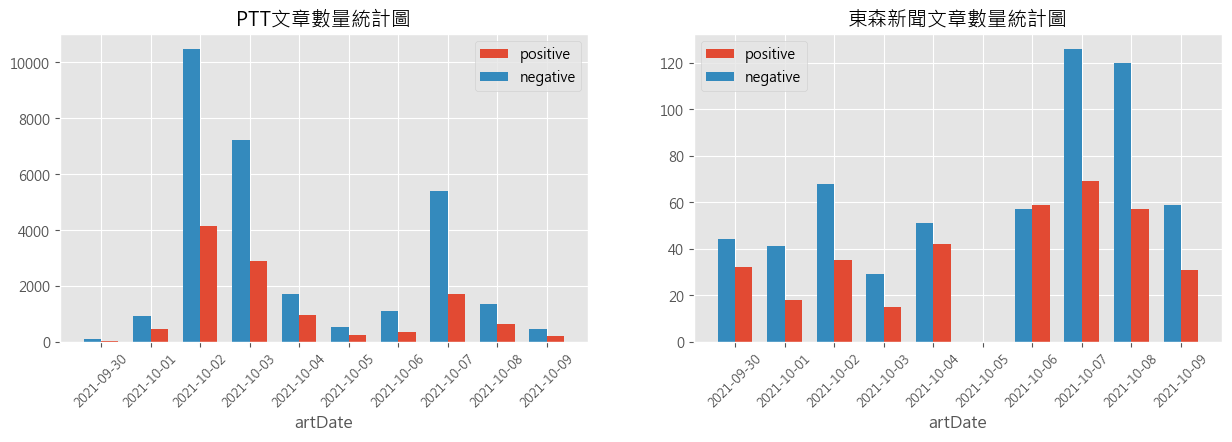

In [72]:
PTT_ap = PTT_senti_sum[PTT_senti_sum["sentiments"]=="positive"]
PTT_an = PTT_senti_sum[PTT_senti_sum["sentiments"]=="negative"]
news_ap = news_senti_sum[news_senti_sum["sentiments"]=="positive"]
news_an = news_senti_sum[news_senti_sum["sentiments"]=="negative"]

plt.figure(figsize=(15,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('PTT文章數量統計圖')
plt.xlabel('artDate')
plt.bar(PTT_ap['artDate'],PTT_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(PTT_an['artDate'],PTT_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')


plt.subplot(122)
plt.title('東森新聞文章數量統計圖')
plt.xlabel('artDate')
plt.bar(news_ap['artDate'],news_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(news_an['artDate'],news_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

- 可以看出蠻有趣的一點是：在事件爆發後Ptt幾乎都維持在負面情緒較高的情況。
- 而東森新聞則是在中期(10/04、10/06)的正面情緒較高，後期直播事件後也從正面情緒轉為負面情緒。
- 東森新聞的樣本數相較ptt少很多，在10/05沒有相關事件的新聞資料。